<a href="https://www.kaggle.com/code/megalajeyapal/restaurant-recommendation-1?scriptVersionId=109596890" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelpdataset/yelp_academic_dataset_business.csv
/kaggle/input/yelpdataset/yelp_academic_dataset_user.csv
/kaggle/input/yelpdataset/yelp_academic_dataset_review.csv


In [2]:
## Importing modules

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [3]:
## Importing data
review_data = pd.read_csv('../input/yelpdataset/yelp_academic_dataset_review.csv', usecols= ['business_id', 'stars', 'review_id', 'user_id'])
business_data = pd.read_csv('../input/yelpdataset/yelp_academic_dataset_business.csv', usecols= ['business_id', 'name', 'review_count', 'categories', 'stars'])
user_data = pd.read_csv('../input/yelpdataset/yelp_academic_dataset_user.csv', usecols= ['user_id', 'name'])

## Since users and business dataframe both have the same column names we will update them accordingly
user_data = user_data.rename(columns = { 'name': 'Username' })
business_data = business_data.rename(columns = { 'name': 'Restaurant name' })

In [4]:
print(user_data.columns.values)

['user_id' 'Username']


In [5]:
print(business_data.columns.values)

['business_id' 'categories' 'review_count' 'Restaurant name' 'stars']


In [6]:
print(review_data.columns.values)

['review_id' 'user_id' 'business_id' 'stars']


In [7]:
user_data.isnull().sum()


user_id     0
Username    8
dtype: int64

In [8]:
business_data.isnull().sum()


business_id          0
categories         103
review_count         0
Restaurant name      0
stars                0
dtype: int64

In [9]:
review_data.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
dtype: int64

In [10]:
business_data.head(5)

,business_id,categories,review_count,Restaurant name,stars
0,Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",7,"Abby Rappoport, LAC, CMQ",5.0
1,mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",15,The UPS Store,3.0
2,tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",22,Target,3.5
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,St Honore Pastries,4.0
4,mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",13,Perkiomen Valley Brewery,4.5


In [11]:
business_data.shape

(150346, 5)

In [12]:
business_data['Restaurants'] = business_data['categories'].str.contains('Restaurants')
business_data.head(5)

,business_id,categories,review_count,Restaurant name,stars,Restaurants
0,Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",7,"Abby Rappoport, LAC, CMQ",5.0,False
1,mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",15,The UPS Store,3.0,False
2,tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",22,Target,3.5,False
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,St Honore Pastries,4.0,True
4,mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",13,Perkiomen Valley Brewery,4.5,False


In [13]:
business_restaurant = business_data.loc[business_data.Restaurants == True]
business_restaurant.head(5)

,business_id,categories,review_count,Restaurant name,stars,Restaurants
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,St Honore Pastries,4.0,True
5,CF33F8-E6oudUQ46HnavjQ,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",6,Sonic Drive-In,2.0,True
8,k0hlBqXX-Bt0vf1op7Jr1w,"Pubs, Restaurants, Italian, Bars, American (Tr...",19,Tsevi's Pub And Grill,3.0,True
9,bBDDEgkFA1Otx9Lfe7BZUQ,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",10,Sonic Drive-In,1.5,True
11,eEOYSgkmpB90uNA7lDOMRA,"Vietnamese, Food, Restaurants, Food Trucks",10,Vietnamese Food Truck,4.0,True


In [14]:
business_restaurant.shape

(52268, 6)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


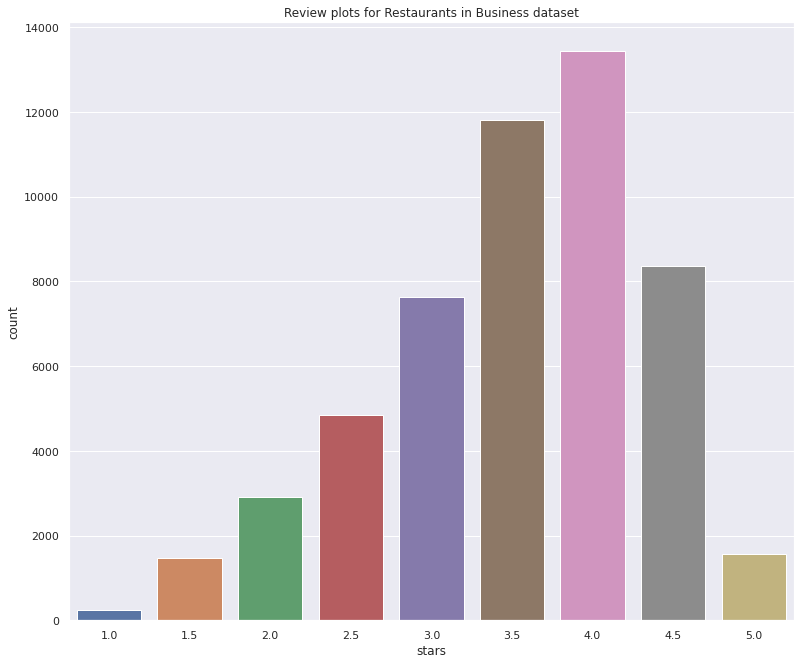

In [16]:
fig, ax = plt.subplots(figsize = (13,11))
sns.countplot(business_restaurant['stars'], ax=ax)
plt.title('Review plots for Restaurants in Business dataset')
plt.show()

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

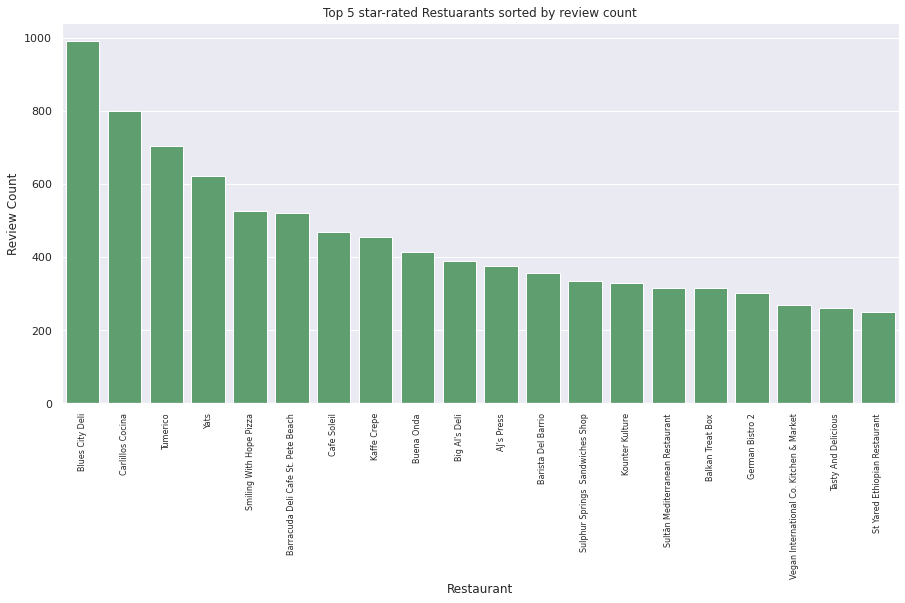

In [17]:
top_res = business_restaurant[business_restaurant["stars"]==5]
top_res = top_res.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='Restaurant name', y="review_count", data=top_res,color="g")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated Restuarants sorted by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

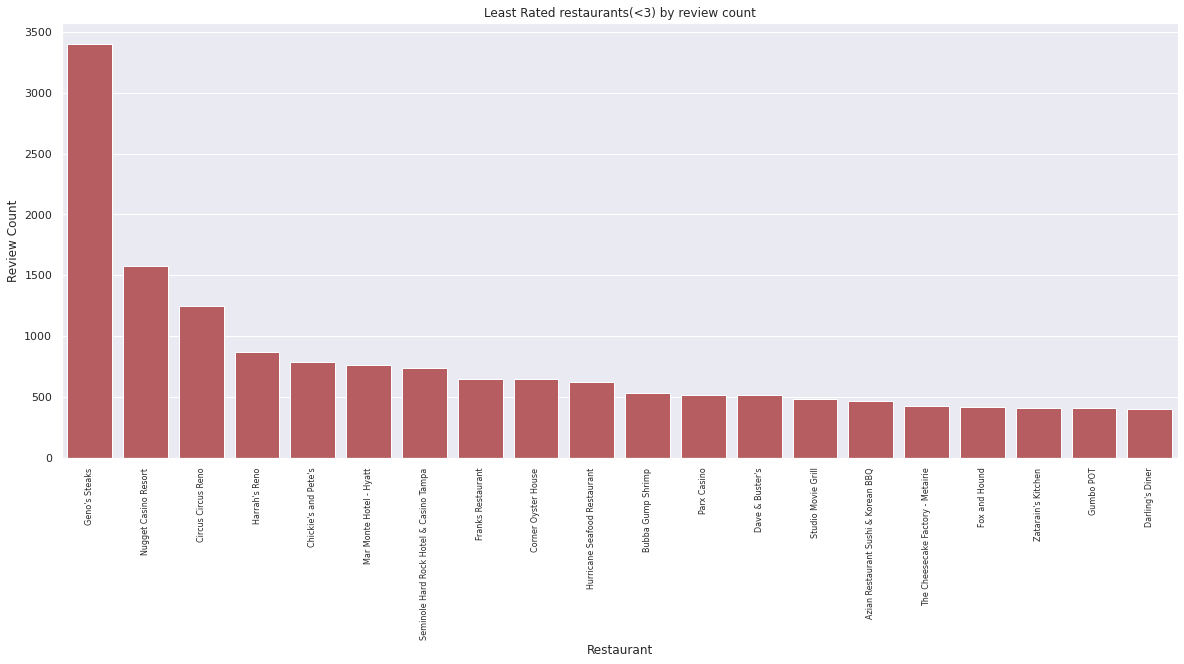

In [18]:
top_res = business_restaurant[business_restaurant["stars"]< 3]
top_res = top_res.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(20,8))
p = sns.barplot(x='Restaurant name', y="review_count", data=top_res,color="r")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Least Rated restaurants(<3) by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

In [19]:
#business_restaurant = business_restaurant[business_restaurant['business_id'].isin(review_data['business_id'])]


In [20]:
# Combine the columns from the given dataframe to consist only of required columns for model
ratings_data = review_data.join(business_restaurant.set_index('business_id'), on='business_id',  how='left', lsuffix='_review', rsuffix='_business')
ratings_data = ratings_data.join(user_data.set_index('user_id'), on = 'user_id', how='left', lsuffix='_left', rsuffix='_right')
ratings_data.head()

,review_id,user_id,business_id,stars_review,categories,review_count,Restaurant name,stars_business,Restaurants,Username
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"Restaurants, Breakfast & Brunch, Food, Juice B...",169.0,Turning Point of North Wales,3.0,True,Melanie
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,NaN,NaN,NaN,NaN,NaN,Erin
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,"Restaurants, Breakfast & Brunch",47.0,Kettle Restaurant,3.5,True,Debra
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Halal, Pakistani, Restaurants, Indian",181.0,Zaika,4.0,True,Kyle
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",32.0,Melt,4.0,True,Sophia


In [21]:
ratings_data_sample = ratings_data.head(1000)

In [22]:
ratings_data.shape

(6990280, 10)

In [23]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(ratings_data_sample[['user_id', 'business_id', 'stars_review']], reader)

# An antiset is a set of those user and item pairs for which a rating doesn't exist in original dataset
# We will use this data for testing
anti_set = data.build_full_trainset().build_anti_testset()
#trainset, testset = train_test_split(data, test_size=0.25)

In [24]:
print(data)

In [25]:
sim_options = { 'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNWithMeans(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3780
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4210
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3865
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3286
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3411


In [26]:
pred_df = pd.DataFrame(best_pred).merge(ratings_data_sample , left_on = ['uid', 'iid'], right_on = ['user_id', 'business_id'])
pred_df[['uid', 'iid',  'Username', 'user_id', 'Restaurant name', 'business_id', 'est','stars_review']]

,uid,iid,Username,user_id,Restaurant name,business_id,est,stars_review
0,jvURGq9nyZkTF1KuSaZC_g,CYwC5OjwCN6ib_AQDxi3Ow,Joshua,jvURGq9nyZkTF1KuSaZC_g,In-N-Out Burger,CYwC5OjwCN6ib_AQDxi3Ow,3.8125,5.0
1,u3QY-afIktF3iUYHiKYT0g,y44MbCvvtmg1FpkNGSWisw,Jacqueline,u3QY-afIktF3iUYHiKYT0g,Tony's Luke,y44MbCvvtmg1FpkNGSWisw,3.8125,1.0
2,INUDMj7EmrLlTh6qDNprAg,8uF-bhJFgT4Tn6DTb27viA,Mack's,INUDMj7EmrLlTh6qDNprAg,District Donuts Sliders Brew,8uF-bhJFgT4Tn6DTb27viA,3.8125,5.0
3,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,Faith,r3zeYsv1XFBRA4dJpL78cw,NaN,gmjsEdUsKpj9Xxu6pdjH0g,3.8125,5.0
4,_bWkbDmhgFURzQ6VsULgtQ,LnQRfj3pPz0369stRnwUWw,Craig,_bWkbDmhgFURzQ6VsULgtQ,Sushi Ushi,LnQRfj3pPz0369stRnwUWw,3.8125,4.0
...,...,...,...,...,...,...,...,...
195,C_2mNjl-doRVvsL03_T57Q,18eWJFJbXyR9j_5xfcRLYA,Richard,C_2mNjl-doRVvsL03_T57Q,Siam Elephant,18eWJFJbXyR9j_5xfcRLYA,3.8125,4.0
196,ZINyxsYek_RF6jrUmQ_zDw,Es39sSDXiReBthHLBSD_Xw,c,ZINyxsYek_RF6jrUmQ_zDw,Phillips Seafood,Es39sSDXiReBthHLBSD_Xw,3.8125,4.0
197,sNYK8_kyxap1klofJnDqHg,bj-_vwEXLa7ECiHZhoOmFg,Chris,sNYK8_kyxap1klofJnDqHg,Dooney's Pub Delran,bj-_vwEXLa7ECiHZhoOmFg,3.8125,4.0
198,wpXPaiDFVl_DCF64IPLOLw,NcO-pWiZmNM5zBg8H9zB6Q,Mike,wpXPaiDFVl_DCF64IPLOLw,La Tavola Ristorante Italiano,NcO-pWiZmNM5zBg8H9zB6Q,3.8125,3.0


In [27]:
anti_pre = best_algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(business_restaurant , left_on = ['iid'], right_on = ['business_id'])
pred_df = pd.DataFrame(pred_df).merge(user_data , left_on = ['uid'], right_on = ['user_id'])

In [28]:
pred_df[:1000]

,uid,iid,r_ui,est,details,business_id,categories,review_count,Restaurant name,stars,Restaurants,user_id,Username
0,mh_-eMZ6K5RLWhZyISBhwA,YjUWPpI6HXG530lwP-fb2A,3.85,3.84625,"{'was_impossible': True, 'reason': 'User and/o...",YjUWPpI6HXG530lwP-fb2A,"Restaurants, Breakfast & Brunch",47,Kettle Restaurant,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
1,mh_-eMZ6K5RLWhZyISBhwA,kxX2SOes4o-D3ZQBkiMRfA,3.85,5.00000,"{'actual_k': 0, 'was_impossible': False}",kxX2SOes4o-D3ZQBkiMRfA,"Halal, Pakistani, Restaurants, Indian",181,Zaika,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
2,mh_-eMZ6K5RLWhZyISBhwA,e4Vwtrqf-wpJfwesgvdgxQ,3.85,4.00000,"{'actual_k': 0, 'was_impossible': False}",e4Vwtrqf-wpJfwesgvdgxQ,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",32,Melt,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
3,mh_-eMZ6K5RLWhZyISBhwA,04UD14gamNjLY0IDYVhHJg,3.85,1.00000,"{'actual_k': 0, 'was_impossible': False}",04UD14gamNjLY0IDYVhHJg,"Mediterranean, Restaurants, Seafood, Greek",273,Dmitri's,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
4,mh_-eMZ6K5RLWhZyISBhwA,LHSTtnW3YHCeUkRDGyJOyw,3.85,5.00000,"{'actual_k': 0, 'was_impossible': False}",LHSTtnW3YHCeUkRDGyJOyw,"Beer Bar, Bars, American (New), Gastropubs, Re...",103,Fries Rebellion,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,OyoGAe7OKpv6SyGZT5g77Q,zVoxVPHEt11_0GzqNuT2ZQ,3.85,4.00000,"{'actual_k': 0, 'was_impossible': False}",zVoxVPHEt11_0GzqNuT2ZQ,"Restaurants, American (New)",186,Home Wine Kitchen,4.0,True,OyoGAe7OKpv6SyGZT5g77Q,Erin
996,OyoGAe7OKpv6SyGZT5g77Q,aZNiVR6oAMQX5__yGPvYsg,3.85,3.00000,"{'actual_k': 0, 'was_impossible': False}",aZNiVR6oAMQX5__yGPvYsg,"Chinese, Restaurants",26,Susanna Foo Chinese Cuisine,3.5,True,OyoGAe7OKpv6SyGZT5g77Q,Erin
997,OyoGAe7OKpv6SyGZT5g77Q,-K0zTgGyxo-AeSkcV0IVaA,3.85,5.00000,"{'actual_k': 0, 'was_impossible': False}",-K0zTgGyxo-AeSkcV0IVaA,"Mediterranean, Restaurants",158,Spiro's Restaurant,4.5,True,OyoGAe7OKpv6SyGZT5g77Q,Erin
998,OyoGAe7OKpv6SyGZT5g77Q,LT4A5jVMURvH_DKdr7A91w,3.85,3.84625,"{'was_impossible': True, 'reason': 'User and/o...",LT4A5jVMURvH_DKdr7A91w,"Sandwiches, Barbeque, Restaurants, Food",65,Big Q BBQ,2.5,True,OyoGAe7OKpv6SyGZT5g77Q,Erin


In [29]:
## Recommend a restaurant to the user if the estimated rating is equal to 5

pred_df[(pred_df['est'] == 5)&(pred_df['user_id']=='mh_-eMZ6K5RLWhZyISBhwA')]

,uid,iid,r_ui,est,details,business_id,categories,review_count,Restaurant name,stars,Restaurants,user_id,Username
1,mh_-eMZ6K5RLWhZyISBhwA,kxX2SOes4o-D3ZQBkiMRfA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",kxX2SOes4o-D3ZQBkiMRfA,"Halal, Pakistani, Restaurants, Indian",181,Zaika,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
4,mh_-eMZ6K5RLWhZyISBhwA,LHSTtnW3YHCeUkRDGyJOyw,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",LHSTtnW3YHCeUkRDGyJOyw,"Beer Bar, Bars, American (New), Gastropubs, Re...",103,Fries Rebellion,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
10,mh_-eMZ6K5RLWhZyISBhwA,BVndHaLihEYbr76Z0CMEGw,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",BVndHaLihEYbr76Z0CMEGw,"Sandwiches, Restaurants, American (New), Ameri...",162,Mamas Kitchen,4.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
11,mh_-eMZ6K5RLWhZyISBhwA,YtSqYv1Q_pOltsVPSx54SA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",YtSqYv1Q_pOltsVPSx54SA,"Wine Bars, Restaurants, Nightlife, Steakhouses...",290,Rittenhouse Grill,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
13,mh_-eMZ6K5RLWhZyISBhwA,eFvzHawVJofxSnD7TgbZtg,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",eFvzHawVJofxSnD7TgbZtg,"Food, Cafes, Coffee & Tea, Restaurants",249,Good Karma Cafe,4.0,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,mh_-eMZ6K5RLWhZyISBhwA,F1xE--Gb4rNFAwHkNkV31A,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",F1xE--Gb4rNFAwHkNkV31A,"Pizza, Vegan, Restaurants, Beer, Wine & Spirit...",278,Eclipse Pizza Co.,4.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
548,mh_-eMZ6K5RLWhZyISBhwA,L-YdO_NODKXXT3bkS0nUpg,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",L-YdO_NODKXXT3bkS0nUpg,"American (Traditional), Restaurants, Bars, Sea...",664,RumFish Grill,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
549,mh_-eMZ6K5RLWhZyISBhwA,L7i_5DydYEKwPLfcDBRYDA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",L7i_5DydYEKwPLfcDBRYDA,"Mexican, Fast Food, Restaurants",44,Chipotle Mexican Grill,2.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie
551,mh_-eMZ6K5RLWhZyISBhwA,1_hDCN3iioFR3XnUr32ZtA,3.85,5.0,"{'actual_k': 0, 'was_impossible': False}",1_hDCN3iioFR3XnUr32ZtA,"Fast Food, Turkish, German, Greek, Mediterrane...",109,Dooners,3.5,True,mh_-eMZ6K5RLWhZyISBhwA,Melanie


In [30]:
## get restaurants recommendations for given user

def get_recommendations(user_id, estimated_prediction):
    df_recommended = pred_df[(pred_df['est'] >= estimated_prediction) & (pred_df['user_id'] == user_id)]
    restaurants = df_recommended['Restaurant name']
    return restaurants

In [31]:
user_data.head(100)

,user_id,Username
0,qVc8ODYU5SZjKXVBgXdI7w,Walker
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel
2,2WnXYQFK0hXEoTxPtV2zvg,Steph
3,SZDeASXq7o05mMNLshsdIA,Gwen
4,hA5lMy-EnncsH4JoR-hFGQ,Karen
...,...,...
95,8m2LgacB5VeP_1Mn5ZMC4w,Alan
96,MvOXPiqRr9IjqVtwC5mUNA,Jessica
97,PrJ37Ik9DxritxGPqI9ktw,David
98,dHLL7SVGJw5uM6IEp_wb4Q,Constance


In [32]:
user = 'OyoGAe7OKpv6SyGZT5g77Q'
recommendations = get_recommendations(user, 5)

print('\n\nRecommendations are listed below for userid ', user)
print('\n Top 10 Recommended Restaurants')
print(recommendations[:10])




Recommendations are listed below for userid  OyoGAe7OKpv6SyGZT5g77Q

 Top 10 Recommended Restaurants
555                              Zaika
558                    Fries Rebellion
564                      Mamas Kitchen
565                  Rittenhouse Grill
567                    Good Karma Cafe
574          Anthony's at Paxon Hollow
576                    Portobello Cafe
577    The Original Habit Burger Grill
578                               Wawa
579               Helena Avenue Bakery
Name: Restaurant name, dtype: object
